# Jacobi Solver sanity check

In [183]:
import numpy as np
from time import time
from numpy.linalg import norm
from naviflow_oo.solver.pressure_solver.helpers.rhs_construction import get_rhs
from naviflow_oo.solver.pressure_solver.helpers.matrix_free import compute_Ap_product
from naviflow_oo.preprocessing.mesh.structured import StructuredMesh


print(f"Loading arrays for pressure solving")
u_star = np.load('arrays_65x65/u_star.npy')
v_star = np.load('arrays_65x65/v_star.npy')
d_u = np.load('arrays_65x65/d_u.npy')
d_v = np.load('arrays_65x65/d_v.npy')
p_star = np.load('arrays_65x65/p_star.npy')
p_prime = np.load('arrays_65x65/p_prime.npy')
print(f"u_star shape: {u_star.shape}")
print(f"v_star shape: {v_star.shape}")
print(f"d_u shape: {d_u.shape}")
print(f"d_v shape: {d_v.shape}")
print(f"p_star shape: {p_star.shape}")
print(f"p_prime shape: {p_prime.shape}")

Loading arrays for pressure solving
u_star shape: (128, 127)
v_star shape: (127, 128)
d_u shape: (128, 127)
d_v shape: (127, 128)
p_star shape: (127, 127)
p_prime shape: (127, 127)


In [184]:
# Create mesh and setup
nx, ny = 35, 35 
mesh = StructuredMesh(nx=nx, ny=ny, length=1.0, height=1.0)
dx, dy = mesh.get_cell_sizes()
F = get_rhs(mesh.nx, mesh.ny, mesh.dx, mesh.dy, 1.0, u_star, v_star)

In [185]:
# Set parameters for Jacobi solver
omega = 0.5 
max_iterations = 100

In [186]:

# Import the Jacobi solver
from naviflow_oo.solver.pressure_solver.jacobi import JacobiSolver

# Create Jacobi solver instance
jacobi_solver = JacobiSolver(omega=omega, max_iterations=max_iterations, tolerance=1e-20)

# Initial guess (zeros)
u_jacobi = np.zeros((mesh.nx, mesh.ny))  # Start with 2D array of zeros

# Run Jacobi solver and track convergence
residuals = []
errors_2 = []
errors_inf = []
# Calculate initial error
initial_error = norm((p_prime - u_jacobi).flatten(), np.inf) / norm(p_prime.flatten(), np.inf)
initial_error_2 = norm((p_prime - u_jacobi).flatten(), 2) / norm(p_prime.flatten(), 2)
errors_2.append(initial_error_2)
errors_inf.append(initial_error)

print(f"Initial error (relative to benchmark): {initial_error:.6e}")



Initial error (relative to benchmark): 1.000000e+00


In [187]:

# Apply Jacobi iterations using the main solver
for i in range(1, max_iterations+1):  # Run in groups of 5 iterations for speed
    # Apply 5 iterations of the improved Jacobi method
    u_jacobi = jacobi_solver.solve(
        p=u_jacobi,            
        b=F,                    
        nx=mesh.nx,             
        ny=mesh.ny,             
        dx=dx,                  
        dy=dy,                  
        rho=1.0,                
        d_u=d_u,                
        d_v=d_v,                
        num_iterations=1,       
        track_residuals=False   
    )
    
    # Calculate residual 
    u_jacobi_flat = u_jacobi.flatten('F')
    r = F - compute_Ap_product(u_jacobi_flat, mesh.nx, mesh.ny, dx, dy, 1.0, d_u, d_v)
    res_norm =   norm(F, 2)/norm(r, 2)
    residuals.append(res_norm)
    
    # Calculate error directly
    error_2 = norm((p_prime - u_jacobi).flatten(), 2) / norm(p_prime.flatten(), 2)
    errors_2.append(error_2)
    error_inf = norm((p_prime - u_jacobi).flatten(), np.inf) / norm(p_prime.flatten(), np.inf)
    errors_inf.append(error_inf)
    

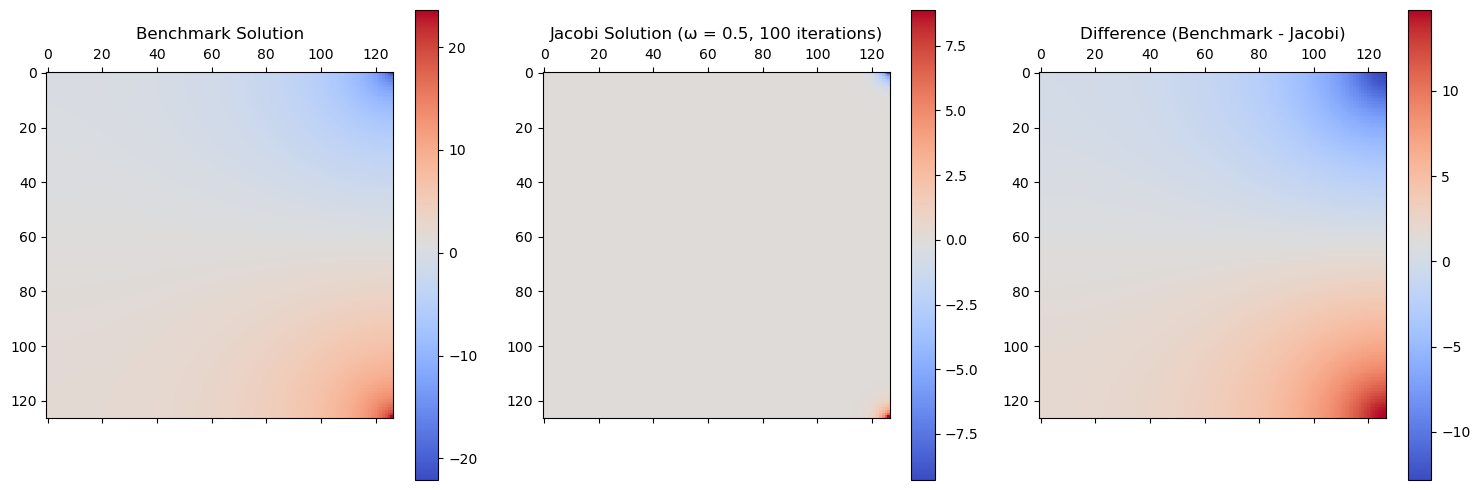

In [188]:
import matplotlib.pyplot as plt
import scienceplots


# Reshape solutions for plotting
p_prime_2d = p_prime.reshape((mesh.nx, mesh.ny))
u_jacobi_2d = u_jacobi.reshape((mesh.nx, mesh.ny))

# Compute the difference
diff = p_prime_2d - u_jacobi_2d

# Plot solutions side by side
plt.figure(figsize=(15, 5))

# Plot benchmark solution
plt.subplot(1, 3, 1)
im1 = plt.matshow(p_prime_2d, cmap='coolwarm', fignum=False)
plt.colorbar(im1)
plt.title('Benchmark Solution')

# Plot Jacobi solution
plt.subplot(1, 3, 2)
im2 = plt.matshow(u_jacobi_2d, cmap='coolwarm', fignum=False)
plt.colorbar(im2)
plt.title(f'Jacobi Solution (ω = {omega}, {max_iterations} iterations)')

# Plot difference
plt.subplot(1, 3, 3)
im3 = plt.matshow(diff, cmap='coolwarm', fignum=False)
plt.colorbar(im3)
plt.title('Difference (Benchmark - Jacobi)')

plt.tight_layout()
plt.show()

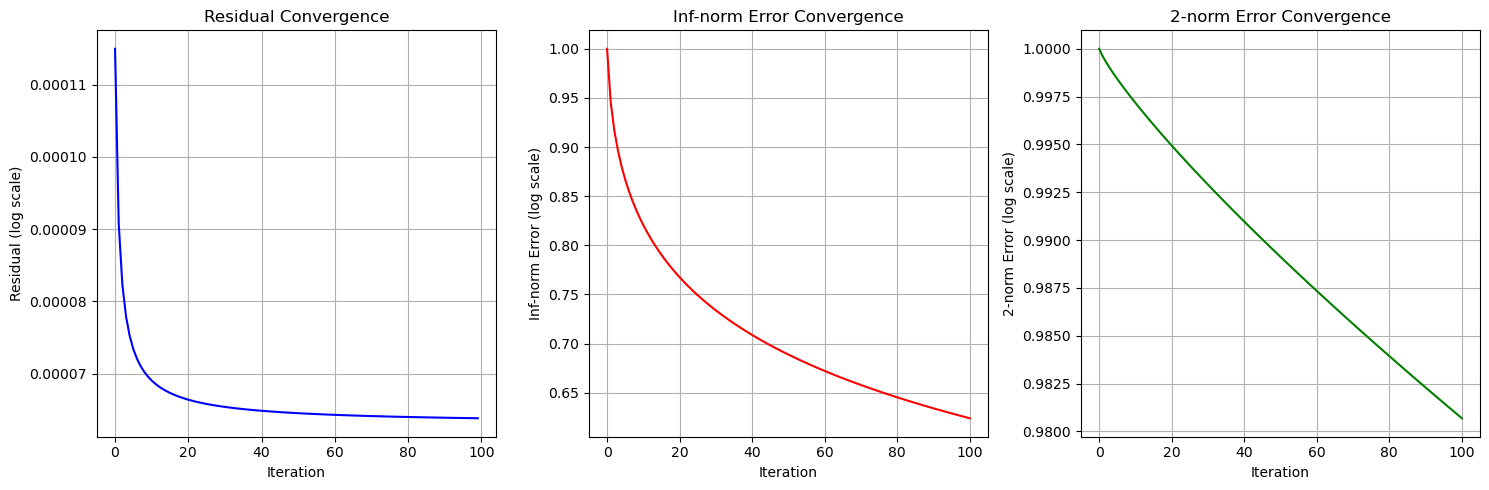

In [189]:
# Plot convergence history
plt.figure(figsize=(15, 5))

# Plot residual history
plt.subplot(1, 3, 1)
plt.plot(range(len(residuals)), residuals, 'b-')
plt.xlabel('Iteration')
plt.ylabel('Residual (log scale)')
plt.title('Residual Convergence')
plt.grid(True)

# Plot inf-norm error history
plt.subplot(1, 3, 2)
plt.plot(range(len(errors_inf)), errors_inf, 'r-')
plt.xlabel('Iteration')
plt.ylabel('Inf-norm Error (log scale)')
plt.title('Inf-norm Error Convergence')
plt.grid(True)

# Plot 2-norm error history
plt.subplot(1, 3, 3)
plt.plot(range(len(errors_2)), errors_2, 'g-')
plt.xlabel('Iteration')
plt.ylabel('2-norm Error (log scale)')
plt.title('2-norm Error Convergence')
plt.grid(True)

plt.tight_layout()

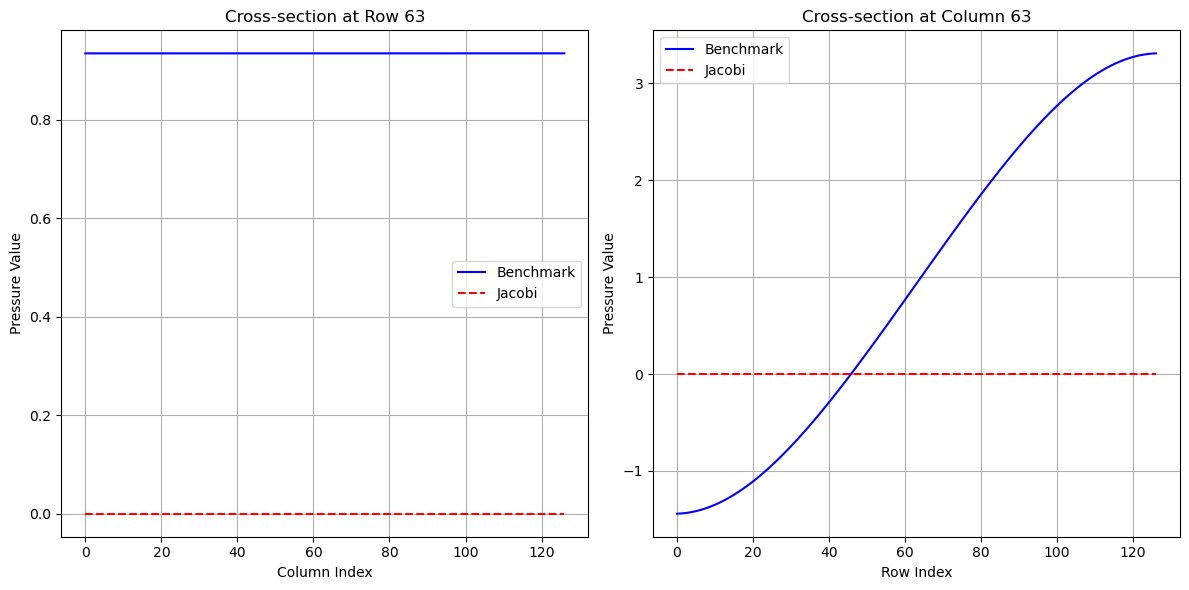

In [190]:

# Also create a cross-section plot to better visualize the differences
plt.figure(figsize=(12, 6))

# Plot cross-section at the middle row
mid_row = mesh.nx // 2
plt.subplot(1, 2, 1)
plt.plot(p_prime_2d[mid_row, :], 'b-', label='Benchmark')
plt.plot(u_jacobi_2d[mid_row, :], 'r--', label='Jacobi')
plt.title(f'Cross-section at Row {mid_row}')
plt.xlabel('Column Index')
plt.ylabel('Pressure Value')
plt.legend()
plt.grid(True)

# Plot cross-section at the middle column
mid_col = mesh.ny // 2
plt.subplot(1, 2, 2)
plt.plot(p_prime_2d[:, mid_col], 'b-', label='Benchmark')
plt.plot(u_jacobi_2d[:, mid_col], 'r--', label='Jacobi')
plt.title(f'Cross-section at Column {mid_col}')
plt.xlabel('Row Index')
plt.ylabel('Pressure Value')
plt.legend()
plt.grid(True)

plt.tight_layout()

In [191]:

print("\n====== Jacobi Benchmark Summary ======")
print(f"Omega = {omega}")
print(f"Number of iterations: {max_iterations}")
if len(residuals) > 0:
    print(f"Initial residual: {residuals[0]:.6e}")
    print(f"Final residual: {residuals[-1]:.6e}")
    print(f"Residual reduction: {residuals[0]/residuals[-1]:.2f}x")
print(f"Initial inf norm error vs benchmark: {errors_inf[0]:.6e}")
print(f"Final inf norm error vs benchmark: {errors_inf[-1]:.6e}")
print(f"Error reduction: {errors_inf[0]/errors_inf[-1]:.2f}x")
print(f"Initial 2 norm error vs benchmark: {errors_2[0]:.6e}")
print(f"Final 2 norm error vs benchmark: {errors_2[-1]:.6e}")
print(f"Error reduction: {errors_2[0]/errors_2[-1]:.2f}x")


====== Jacobi Benchmark Summary ======
Omega = 0.5
Number of iterations: 100
Initial residual: 1.149853e-04
Final residual: 6.380438e-05
Residual reduction: 1.80x
Initial inf norm error vs benchmark: 1.000000e+00
Final inf norm error vs benchmark: 6.239685e-01
Error reduction: 1.60x
Initial 2 norm error vs benchmark: 1.000000e+00
Final 2 norm error vs benchmark: 9.806879e-01
Error reduction: 1.02x


# Finding optimal value of Omega


In [192]:
import numpy as np
import scipy.sparse as sp
import scipy.linalg as la

def get_coeff_matrix(nx, ny, dx, dy, rho, d_u, d_v):
    # Reconstruct the coefficient matrix A based on the SIMPLE data.
    aE = np.zeros((nx, ny))
    aW = np.zeros((nx, ny))
    aN = np.zeros((nx, ny))
    aS = np.zeros((nx, ny))
    aP = np.zeros((nx, ny))
    
    # Fill in the coefficient matrices (these should already be constructed in your data)
    aE[:-1, :] = rho * d_u[1:nx, :] * dy
    aW[1:, :] = rho * d_u[1:nx, :] * dy
    aN[:, :-1] = rho * d_v[:, 1:ny] * dx
    aS[:, 1:] = rho * d_v[:, 1:ny] * dx
    
    aP = aE + aW + aN + aS
    
    # Convert to sparse matrix format for memory efficiency
    A = sp.lil_matrix((nx * ny, nx * ny))
    
    # Populate matrix A based on coefficients
    for i in range(nx):
        for j in range(ny):
            idx = i * ny + j  # Flattened index
            
            if i < nx - 1:  # East
                A[idx, idx + ny] = -aE[i, j]
            if i > 0:  # West
                A[idx, idx - ny] = -aW[i, j]
            if j < ny - 1:  # North
                A[idx, idx + 1] = -aN[i, j]
            if j > 0:  # South
                A[idx, idx - 1] = -aS[i, j]
                
            # Diagonal coefficient
            A[idx, idx] = aP[i, j]
    
    return A

def spectral_analysis(A):
    # Perform spectral analysis
    # Compute eigenvalues and spectral radius (max eigenvalue in absolute value)
    eigenvalues = la.eigvals(A.toarray())  # Convert sparse to dense for eigvals calculation
    spectral_radius = np.max(np.abs(eigenvalues))
    
    print(f"Spectral Radius: {spectral_radius:.6f}")
    
    # Optionally: Check first few eigenvalues for stability analysis
    print("Eigenvalues:", eigenvalues[:10])
    
    return eigenvalues, spectral_radius

# Example usage:
# nx, ny, dx, dy, rho, d_u, d_v should be defined earlier as per your data
rho= 1
#A = get_coeff_matrix(nx, ny, dx, dy, rho, d_u, d_v)
#eigenvalues, spectral_radius = spectral_analysis(A)


# Multigrid debuuuug

In [193]:

def restriction(fine_grid):
    if fine_grid.ndim == 3:
        return fine_grid

    nx, ny = fine_grid.shape
    nx_coarse = (nx + 1) // 2
    ny_coarse = (ny + 1) // 2
    
    coarse_grid = np.zeros((nx_coarse, ny_coarse))
    
    # Interior points - full weighting
    for i in range(1, nx_coarse-1):
        for j in range(1, ny_coarse-1):
            # Full weighting stencil:
            #   1 2 1
            #   2 4 2   / 16
            #   1 2 1
            i_fine = 2*i
            j_fine = 2*j
            
            coarse_grid[i, j] = (
                4 * fine_grid[i_fine, j_fine] +
                2 * (fine_grid[i_fine-1, j_fine] + fine_grid[i_fine+1, j_fine] + 
                        fine_grid[i_fine, j_fine-1] + fine_grid[i_fine, j_fine+1]) +
                1 * (fine_grid[i_fine-1, j_fine-1] + fine_grid[i_fine+1, j_fine-1] +
                        fine_grid[i_fine-1, j_fine+1] + fine_grid[i_fine+1, j_fine+1])
            ) / 16.0
   
    return coarse_grid

def bilinear_interpolate(coarse_grid, m):
    
    # Get the shape of the coarse grid
    nc_x, nc_y = coarse_grid.shape
   
    # Initialize fine grid with zeros (properly sized for rectangular grids)
    fine_grid = np.zeros((nx, ny))
    
    # Direct injection: copy coarse grid values to fine grid at even indices
    for i in range(nc_x):
        for j in range(nc_y):
            if 2*i < nx and 2*j < ny:
                fine_grid[2*i, 2*j] = coarse_grid[i, j]
    
    # Interpolate horizontally (even rows, odd columns)
    for i in range(nc_x):
        for j in range(nc_y-1):
            if 2*i < nx and 2*j+1 < ny:
                fine_grid[2*i, 2*j+1] = 0.5 * (fine_grid[2*i, 2*j] + fine_grid[2*i, 2*j+2])
    
    # Interpolate vertically (odd rows, even columns)
    for i in range(nc_x-1):
        for j in range(nc_y):
            if 2*i+1 < nx and 2*j < ny:
                fine_grid[2*i+1, 2*j] = 0.5 * (fine_grid[2*i, 2*j] + fine_grid[2*i+2, 2*j])
    
    # Interpolate diagonally (odd rows, odd columns)
    for i in range(nc_x-1):
        for j in range(nc_y-1):
            if 2*i+1 < nx and 2*j+1 < ny:
                fine_grid[2*i+1, 2*j+1] = 0.25 * (
                    fine_grid[2*i, 2*j] + 
                    fine_grid[2*i+2, 2*j] + 
                    fine_grid[2*i, 2*j+2] + 
                    fine_grid[2*i+2, 2*j+2]
                )
    
    return fine_grid
def quadratic_interpolate(coarse_grid, m):
    
    # Get the shape of the coarse grid
    nc_x, nc_y = coarse_grid.shape
   
    # Initialize fine grid with zeros (properly sized for rectangular grids)
    fine_grid = np.zeros((nx, ny))
    
    # Direct injection: copy coarse grid values to fine grid at even indices
    for i in range(nc_x):
        for j in range(nc_y):
            if 2*i < nx and 2*j < ny:
                fine_grid[2*i, 2*j] = coarse_grid[i, j]
    
    # Interpolate horizontally (even rows, odd columns) using quadratic interpolation
    for i in range(nc_x):
        for j in range(1, nc_y-1):
            if 2*i < nx and 2*j+1 < ny:
                fine_grid[2*i, 2*j+1] = (-0.0625 * fine_grid[2*i, 2*j-2] + 
                                        0.5625 * fine_grid[2*i, 2*j] + 
                                        0.5625 * fine_grid[2*i, 2*j+2] - 
                                        0.0625 * fine_grid[2*i, 2*j+4])
    
    # Interpolate vertically (odd rows, even columns) using quadratic interpolation
    for i in range(1, nc_x-1):
        for j in range(nc_y):
            if 2*i+1 < nx and 2*j < ny:
                fine_grid[2*i+1, 2*j] = (-0.0625 * fine_grid[2*i-2, 2*j] +
                                        0.5625 * fine_grid[2*i, 2*j] +
                                        0.5625 * fine_grid[2*i+2, 2*j] -
                                        0.0625 * fine_grid[2*i+4, 2*j])
    
    # Interpolate diagonally (odd rows, odd columns) using quadratic interpolation
    for i in range(1, nc_x-1):
        for j in range(1, nc_y-1):
            if 2*i+1 < nx and 2*j+1 < ny:
                # Use 16-point stencil for quadratic interpolation
                fine_grid[2*i+1, 2*j+1] = (
                    9/16 * (fine_grid[2*i, 2*j] + fine_grid[2*i+2, 2*j] + 
                           fine_grid[2*i, 2*j+2] + fine_grid[2*i+2, 2*j+2]) -
                    1/16 * (fine_grid[2*i-2, 2*j] + fine_grid[2*i+4, 2*j] +
                           fine_grid[2*i, 2*j-2] + fine_grid[2*i, 2*j+4] +
                           fine_grid[2*i+2, 2*j-2] + fine_grid[2*i+2, 2*j+4] +
                           fine_grid[2*i-2, 2*j+2] + fine_grid[2*i+4, 2*j+2])
                )
    
    return fine_grid


def restrict_coefficients(self, d_u: np.ndarray, d_v: np.ndarray, nx: int, ny: int) -> tuple:
    """
    Restrict momentum equation coefficients from fine to coarse grid using full weighting.
    Full weighting averages values from the fine grid to create the coarse grid,
    preserving more information than simple injection.
    
    Parameters:
    -----------
    d_u, d_v : ndarray
        Momentum equation coefficients on the fine grid
    nx, ny : int
        Dimensions of the fine grid
        
    Returns:
    --------
    tuple
        d_u_coarse, d_v_coarse - Momentum equation coefficients on the coarse grid
    """
    # Compute coarse grid dimensions
    nx_coarse = (nx + 1) // 2
    ny_coarse = (ny + 1) // 2
    
    # Create coarse grid arrays with correct dimensions
    d_u_coarse = np.zeros((nx_coarse+1, ny_coarse))
    d_v_coarse = np.zeros((nx_coarse, ny_coarse+1))
    
    # Full weighting for d_u
    for i in range(1, nx_coarse):
        for j in range(1, ny_coarse-1):
            i_fine = 2*i
            j_fine = 2*j
            if i_fine < d_u.shape[0] and j_fine < d_u.shape[1]:
                d_u_coarse[i,j] = (
                    4 * d_u[i_fine, j_fine] +
                    2 * (d_u[i_fine, j_fine-1] + d_u[i_fine, j_fine+1]) +
                    1 * (d_u[i_fine-1, j_fine-1] + d_u[i_fine-1, j_fine+1])
                ) / 16.0

    # Full weighting for d_v
    for i in range(1, nx_coarse-1):
        for j in range(1, ny_coarse):
            i_fine = 2*i
            j_fine = 2*j
            if i_fine < d_v.shape[0] and j_fine < d_v.shape[1]:
                d_v_coarse[i,j] = (
                    4 * d_v[i_fine, j_fine] +
                    2 * (d_v[i_fine-1, j_fine] + d_v[i_fine+1, j_fine]) +
                    1 * (d_v[i_fine-1, j_fine-1] + d_v[i_fine+1, j_fine-1])
                ) / 16.0

    
    return d_u_coarse, d_v_coarse


## Pseudo vcycle loop

In [194]:
# Create Jacobi solver instance
omega = 0.9 
max_iterations = 5
smooth = JacobiSolver(omega=omega, max_iterations=max_iterations, tolerance=1e-20)


In [195]:
def vcycle(u_coarse, F, mesh, max_v_its, nx, ny, dx, dy, rho, d_u, d_v):
    # Pre smooth  
    U = smooth.solve(p=u_coarse, b=F, nx=nx, ny=ny, dx=dx, dy=dy, rho=rho, d_u=d_u, d_v=d_v)
    
    # Residual
    r = F - compute_Ap_product(U.flatten('F'), nx, ny, dx, dy, rho, d_u, d_v)
    # Restrict residual
    r_coarse = restriction(r)

    # Restrict d_u and d_v
    d_u_coarse, d_v_coarse = restrict_coefficients(d_u, d_v, nx, ny)

    # Solve coarse grid correction

    e_coarse = vcycle(r_coarse, F, mesh, max_v_its, (nx+1)//2, (ny+1)//2, dx/2, dy/2, rho, d_u_coarse, d_v_coarse)
    
    # Prolongate correction
    e = bilinear_interpolate(e_coarse, nx, ny)

    # Update solution
    U += e


    return U 

In [196]:
max_v_its = 1 
epsilon = 1e-6

F = get_rhs(mesh.nx, mesh.ny, mesh.dx, mesh.dy, 1.0, u_star, v_star)
u_vcycle = np.zeros((mesh.nx, mesh.ny))

for i in range(max_v_its):
    u_vcycle = vcycle(u_vcycle, F, mesh, max_v_its, mesh.nx, mesh.ny, mesh.dx, mesh.dy, 1.0, d_u, d_v)
    R = F - compute_Ap_product(u_vcycle.flatten('F'), mesh.nx, mesh.ny, mesh.dx, mesh.dy, 1.0, d_u, d_v)
    res_norm = norm(R, 2)/norm(F, 2)
    residuals.append(res_norm)

    print(f"Residual: {res_norm:.6e}")

    if res_norm < epsilon:
        print(f"Converged in {i+1} iterations")
        break



ValueError: not enough values to unpack (expected 2, got 1)